<a href="https://colab.research.google.com/github/DoggoWoofWoof/Implementation-of-GANS/blob/main/Twin_Model(working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Git
!apt-get install -y git

# Clone the repository with sparse checkout enabled
!git clone --depth 1 --filter=blob:none --sparse https://github.com/DoggoWoofWoof/Implementation-of-GANS.git

# Navigate to the repository directory and checkout the specific folder
%cd Implementation-of-GANS
!git sparse-checkout init --cone
!git sparse-checkout set "Sketch2Face Implementations/Twin Model Dataset (CUHK 13 epoch)"

# Move the combined folder to the parent directory
!mv "Sketch2Face Implementations/Dataset for Sketch2Face/combined" ../combined

# Navigate back to the parent directory
%cd ..

# Remove the cloned repository
!rm -rf Implementation-of-GANS

# Verify the contents of the combined folder
!ls combined


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'Implementation-of-GANS'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 0), reused 48 (delta 0), pack-reused 0
Receiving objects: 100% (50/50), 3.85 MiB | 9.19 MiB/s, done.
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 1.14 KiB | 1.14 MiB/s, done.
/content/Implementation-of-GANS
remote: Enumerating objects: 7456, done.
remote: Counting objects: 100% (7456/7456), done.
remote: Compressing objects: 100% (7456/7456), done.
remote: Total 7456 (delta 0), reused 7456 (delta 0), pa

In [ ]:
from __future__ import print_function, division

import os
import sys
import datetime
import glob
import pickle

import numpy as np
import scipy
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model

from sklearn.utils import shuffle

from skimage.metrics import structural_similarity as ssim

# TensorFlow and Keras imports
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, Concatenate,
    BatchNormalization, Activation, ZeroPadding2D, LeakyReLU,
    UpSampling2D, Conv2D
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import natsort

In [ ]:
def random_shearing(img, num, border):
    rows = img.shape[0]
    cols = img.shape[1]
    if num == 0:
        pts1 = np.float32([[5,5],[20,5],[2,20]])
        pts2 = np.float32([[10,10],[20,5],[5,25]])
    elif num == 1:
        pts1 = np.float32([[5,5],[15,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 2:
        pts1 = np.float32([[5,5],[15,5],[5,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 3:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,25]])
    elif num == 4:
        pts1 = np.float32([[5,5],[10,5],[2,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    else:
        pts1 = np.float32([[5,5],[10,5],[10,20]])
        pts2 = np.float32([[5,10],[10,10],[5,30]])
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img, M, (cols,rows), borderValue=border)

def random_rotation(img, degree, border):
    rows = img.shape[0]
    cols = img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),degree,1)
    return cv2.warpAffine(img,M,(cols,rows), borderValue=border)

def transform_image(img, skt, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Border
    idx = 0
    border_img = tuple([int(img[idx][0][0]), int(img[idx][0][1]), int(img[idx][0][2])])
    border_skt = tuple([int(skt[0][0][0]), int(skt[0][0][1]), int(skt[0][0][2])])

    img = cv2.warpAffine(img,Rot_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,Trans_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,shear_M,(cols,rows), borderValue=border_img)

    skt = cv2.warpAffine(skt,Rot_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,Trans_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,shear_M,(cols,rows), borderValue=border_skt)

    return img, skt


In [ ]:
def augment_images(photo_dir, sketch_dir, photo_glob_pattern, sketch_glob_pattern, num_augmentations=15):
    # Create directories if they don't exist
    os.makedirs(photo_dir, exist_ok=True)
    os.makedirs(sketch_dir, exist_ok=True)

    # Get the file names
    p_filenames = sorted(glob.glob(photo_glob_pattern))
    s_filenames = sorted(glob.glob(sketch_glob_pattern))

    # Check if the lengths of the lists match
    if len(p_filenames) != len(s_filenames):
        raise ValueError("The number of photo files and sketch files do not match.")

    counter = 0
    for i in range(len(p_filenames)):
        im = cv2.imread(p_filenames[i])
        sk = cv2.imread(s_filenames[i])

        if im is None or sk is None:
            print(f"Error reading file: {p_filenames[i]} or {s_filenames[i]}")
            continue

        for j in range(num_augmentations):
            img, skt = transform_image(im, sk, 40, 10, 10)

            # Save the augmented images with zero-padded file names
            cv2.imwrite(os.path.join(photo_dir, f'{counter:05d}.jpg'), img)
            cv2.imwrite(os.path.join(sketch_dir, f'{counter:05d}.jpg'), skt)

            counter += 1

augment_images(
    photo_dir='/content/combined/Augmented photos',
    sketch_dir='/content/combined/Augmented sketches',
    photo_glob_pattern='/content/combined/photos/*',
    sketch_glob_pattern='/content/combined/photos/*',
)


In [ ]:
# Helper Functions
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles, reverse=False)

def load_images(list_path, size=(256, 256)):
    img_list = list()
    for filename in list_path:
        pixels = load_img(filename, target_size=size)
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

def summarize_performance(step, g_model, d_model, dataset, model_name, target_dir='', n_samples=3):
    full_target_dir = target_dir
    if full_target_dir and not os.path.exists(full_target_dir):
        os.makedirs(full_target_dir, exist_ok=True)

    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    plt.figure(figsize=(15, 5*n_samples))

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
        if i == 0:
            plt.title('Input', fontsize=12)

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        if i == 0:
            plt.title('Generated', fontsize=12)

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
        if i == 0:
            plt.title('Ground Truth', fontsize=12)

    plt.suptitle(f'{model_name} - Step {step+1}', fontsize=16)

    filename = f'{model_name}_plot_{step+1:06d}.png'
    plt.savefig(os.path.join(full_target_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

    # Save models
    g_model.save(os.path.join(full_target_dir, f'generator_epoch_{step+1}.h5'))
    d_model.save(os.path.join(full_target_dir, f'discriminator_epoch_{step+1}.h5'))

    print(f'Saved performance summary and models for {model_name} at step {step+1}')

def plot_metrics(g_metrics_history, d_metrics_history, g_loss_history, d_loss_history, epoch, model_name):
    plt.figure(figsize=(20, 40))

    metric_names = ['weight_mean', 'weight_std', 'weight_min', 'weight_max', 'weight_sparsity',
                    'activation_mean', 'activation_std', 'activation_min', 'activation_max',
                    'dead_neurons', 'activation_sparsity', 'layer_loss', 'layer_accuracy']

    for i, metric in enumerate(metric_names):
        plt.subplot(7, 2, i+1)
        for layer in g_metrics_history[0].keys():
            if metric in g_metrics_history[0][layer]:
                values = [m[layer][metric] for m in g_metrics_history if metric in m[layer]]
                if values:
                    plt.plot(values, label=f'G: {layer}')
        for layer in d_metrics_history[0].keys():
            if metric in d_metrics_history[0][layer]:
                values = [m[layer][metric] for m in d_metrics_history if metric in m[layer]]
                if values:
                    plt.plot(values, label=f'D: {layer}')
        plt.title(f'{model_name} - {metric.replace("_", " ").title()}', fontsize=14)
        plt.xlabel('Batch', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        if plt.gca().get_legend_handles_labels()[0]:
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tick_params(axis='both', which='major', labelsize=10)

    plt.subplot(7, 2, 14)
    plt.plot(g_loss_history, label='Generator Loss')
    plt.plot(d_loss_history, label='Discriminator Loss')
    plt.title(f'{model_name} - Overall Model Losses', fontsize=14)
    plt.xlabel('Batch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout(pad=3.0)

    # Save the plot with model name in the filename
    plt.savefig(f'Models/{model_name}/metrics_up_to_epoch_{epoch+1}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def network_metrics(model, inputs, targets, is_discriminator=False):
    metrics = {}
    layer_losses = {}
    layer_accuracies = {}

    for layer in model.layers:
        layer_name = layer.name
        metrics[layer_name] = {}
        layer_losses[layer_name] = []
        layer_accuracies[layer_name] = []

        # Weights metrics
        if layer.weights:
            weights = layer.get_weights()[0]
            metrics[layer_name]['weight_mean'] = np.mean(weights)
            metrics[layer_name]['weight_std'] = np.std(weights)
            metrics[layer_name]['weight_min'] = np.min(weights)
            metrics[layer_name]['weight_max'] = np.max(weights)
            metrics[layer_name]['weight_sparsity'] = np.mean(weights == 0)

        # Activation metrics
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            layer_output = tf.keras.backend.function([model.input], [layer.output])([inputs])[0]
            metrics[layer_name]['activation_mean'] = np.mean(layer_output)
            metrics[layer_name]['activation_std'] = np.std(layer_output)
            metrics[layer_name]['activation_min'] = np.min(layer_output)
            metrics[layer_name]['activation_max'] = np.max(layer_output)
            metrics[layer_name]['dead_neurons'] = np.mean(np.all(layer_output <= 0, axis=(0,1,2)))
            metrics[layer_name]['activation_sparsity'] = np.mean(layer_output == 0)

            if isinstance(layer, tf.keras.layers.Conv2D):
                # Resize targets to match the layer output shape
                resized_targets = tf.image.resize(targets, (layer_output.shape[1], layer_output.shape[2]))

                # If the number of channels doesn't match, take only the first 3 channels of layer_output
                if layer_output.shape[-1] != 3:
                    layer_output = layer_output[..., :3]

                layer_loss = tf.reduce_mean(tf.abs(layer_output - resized_targets)).numpy()
                metrics[layer_name]['layer_loss'] = layer_loss

                # Compute accuracy: percentage of pixels within a certain threshold
                threshold = 0.1
                accuracy = tf.reduce_mean(tf.cast(tf.abs(layer_output - resized_targets) < threshold, tf.float32)).numpy()
                metrics[layer_name]['layer_accuracy'] = accuracy

    return metrics

# Generator
def sketch_generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = BatchNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = BatchNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    in_img = Input(shape=img_shape)

    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='sketch_generator')

# Discriminator
def sketch_discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = BatchNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='sketch_discriminator')

# GAN
def sketch_GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='sketch_GAN')
    return model

# Loss Function
def pixel_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def contextual_loss(y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(y_pred, [0,0,0,0], [16, 256, 256, 3]))
    b = tf.image.rgb_to_grayscale(tf.slice(y_true, [0,0,0,0], [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)

    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss(y_true, y_pred):
    px_loss = pixel_loss(y_true, y_pred)
    ctx_loss = contextual_loss(y_true, y_pred)
    return (0.2 * px_loss) + (0.8 * ctx_loss)

def train(d_model, g_model, gan_model, data, target_dir, model_name, n_epochs=1, n_batch=32):
    n_patch = d_model.output_shape[1]
    blue_photo, blue_sketch = data[0], data[1]

    metrics_buffer = []
    all_g_losses = []
    all_d_losses = []
    batch_count = 0

    # Metrics histories for all epochs
    g_metrics_history = []
    d_metrics_history = []
    g_loss_history = []
    d_loss_history = []

    # Ensure directories exist
    os.makedirs(f'Models/{model_name}/metrics', exist_ok=True)
    os.makedirs(f'Models/{model_name}/output_images', exist_ok=True)

    for epoch in range(n_epochs):
        print(f' ========== Epoch {epoch+1} ========== ')
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        try:
            for j in range(int(len(blue_photo)/n_batch)):
                batch_count += 1
                start = int(j*n_batch)
                end = int(min(len(blue_photo), (j*n_batch)+n_batch))

                dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]
                [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
                X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

                # Train discriminator
                d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
                d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
                d_loss = 0.5 * np.add(d_loss1, d_loss2)

                # Train generator
                g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

                # Calculate network metrics
                g_metrics = network_metrics(g_model, X_realA, X_realB)
                d_metrics = network_metrics(d_model, [X_realA, X_fakeB], y_fake, is_discriminator=True)

                g_metrics_history.append(g_metrics)
                d_metrics_history.append(d_metrics)
                g_loss_history.append(g_loss)
                d_loss_history.append(d_loss)

                metrics_buffer.append({
                    'epoch': epoch + 1,
                    'batch': j + 1,
                    'g_loss': g_loss,
                    'd_loss': d_loss,
                    'g_metrics': g_metrics,
                    'd_metrics': d_metrics
                })

                all_g_losses.append(g_loss)
                all_d_losses.append(d_loss)

                # Save batch-level metrics every 10 batches
                if batch_count % 10 == 0:
                    with open(f'Models/{model_name}/metrics/batch_metrics_{batch_count}.pkl', 'wb') as f:
                        pickle.dump(metrics_buffer, f)
                    metrics_buffer = []  # Clear the buffer after saving

                print(f'Batch : {j+1}, D Loss : {d_loss:.3f} | G Loss : {g_loss:.3f}')

            # Plot metrics for all epochs up to this point
            plot_metrics(g_metrics_history, d_metrics_history,
                         g_loss_history, d_loss_history,
                         epoch, model_name)

            # Summarize performance after each epoch
            summarize_performance(epoch, g_model, d_model, dataset, model_name, f'Models/{model_name}/output/', n_samples=3)

        except Exception as e:
            print(f"An error occurred during epoch {epoch+1}: {str(e)}")
            # Save any remaining metrics in the buffer
            if metrics_buffer:
                with open(f'Models/{model_name}/metrics/batch_metrics_incomplete_{batch_count}.pkl', 'wb') as f:
                    pickle.dump(metrics_buffer, f)
            raise

    # Save any remaining metrics in the buffer at the end of training
    if metrics_buffer:
        with open(f'Models/{model_name}/metrics/batch_metrics_final_{batch_count}.pkl', 'wb') as f:
            pickle.dump(metrics_buffer, f)

    print(f"Training completed for model: {model_name}")

# Load Dataset
b_photo_path = '/content/combined/Augmented photos/'
b_sketch_path = '/content/combined/Augmented photos/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

# Define GAN Model
img_shape = (256, 256, 3)

d_model1 = sketch_discriminator(img_shape)

g_model1 = sketch_generator(img_shape)

gan_model1 = sketch_GAN(g_model1, d_model1, img_shape)

opt = Adam(learning_rate=2e-4, beta_1=0.5)

d_model1.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model1.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

# Define the model name
model_name = "sketch_GAN"

# Define the target directory for saving outputs
target_dir = 'Models/'

# Start the training
train(d_model1, g_model1, gan_model1, data=[blue_sketch, blue_photo], target_dir=target_dir, model_name=model_name, n_epochs=1, n_batch=32)

 ========== Epoch 1 ========== 
1/1 [==============================] - 25s 25s/step
Batch : 1, D Loss : 0.995 | G Loss : 57.145
1/1 [==============================] - 25s 25s/step
Batch : 2, D Loss : 1.036 | G Loss : 22.250
1/1 [==============================] - 31s 31s/step
Batch : 3, D Loss : 0.972 | G Loss : 16.330
1/1 [==============================] - 23s 23s/step
Batch : 4, D Loss : 0.926 | G Loss : 13.969
1/1 [==============================] - 25s 25s/step
Batch : 5, D Loss : 0.977 | G Loss : 12.222
1/1 [==============================] - 23s 23s/step
Batch : 6, D Loss : 0.958 | G Loss : 12.001


In [ ]:
def plot_metrics_from_pickle(model_name):
    # Find all pickle files for the specific model
    pickle_files = sorted(glob.glob(f'metrics/{model_name}_batch_metrics_*.pkl'))

    all_metrics = []

    # Load all metrics from pickle files
    for file in pickle_files:
        with open(file, 'rb') as f:
            metrics = pickle.load(f)
            all_metrics.extend(metrics)

    # Extract data for plotting
    epochs = [m['epoch'] for m in all_metrics]
    batches = [m['batch'] for m in all_metrics]
    g_losses = [m['g_loss'] for m in all_metrics]
    d_losses = [m['d_loss'] for m in all_metrics]

    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.title('GAN Losses')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_losses.png')
    plt.show()

    # Plot detailed metrics
    metric_names = ['weight_mean', 'weight_std', 'weight_min', 'weight_max', 'weight_sparsity',
                    'activation_mean', 'activation_std', 'activation_min', 'activation_max',
                    'dead_neurons', 'activation_sparsity', 'layer_loss', 'layer_accuracy']

    plt.figure(figsize=(20, 40))

    for i, metric in enumerate(metric_names):
        plt.subplot(7, 2, i+1)
        for layer in all_metrics[0]['g_metrics'].keys():
            if metric in all_metrics[0]['g_metrics'][layer]:
                values = [m['g_metrics'][layer][metric] for m in all_metrics if metric in m['g_metrics'][layer]]
                if values:
                    plt.plot(values, label=f'G: {layer}')
        for layer in all_metrics[0]['d_metrics'].keys():
            if metric in all_metrics[0]['d_metrics'][layer]:
                values = [m['d_metrics'][layer][metric] for m in all_metrics if metric in m['d_metrics'][layer]]
                if values:
                    plt.plot(values, label=f'D: {layer}')
        plt.title(f'{metric.replace("_", " ").title()}', fontsize=14)
        plt.xlabel('Batch', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        if plt.gca().get_legend_handles_labels()[0]:
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout(pad=3.0)
    plt.savefig(f'{model_name}_detailed_metrics.png', bbox_inches='tight', dpi=300)
    plt.show()

# Call this function after training is complete
plot_metrics_from_pickle(model_name)

1/1 [==============================] - 2s 2s/step


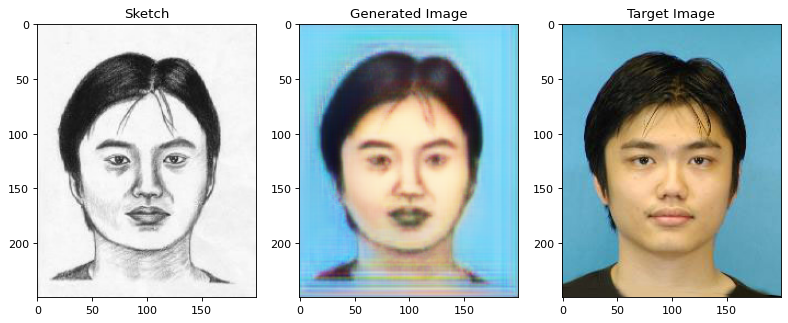

L2-norm: 109.26198323567708 :: SSIM: 0.6645570000459255


In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    norm_img = (img - 127.5) / 127.5
    return img, norm_img

# Function to generate image using the model
def generate_image(model, norm_img):
    g_img = model.predict(np.expand_dims(norm_img, 0))[0]
    g_img = g_img * 127.5 + 127.5
    return np.clip(g_img, 0, 255).astype('uint8')

# Function to load image
def load_image(image_path):
    return cv2.imread(image_path)

# Function to compute L2 norm
def compute_l2(img1, img2):
    return np.mean((np.square(img1 - img2)))

# Function to compute SSIM
def compute_ssim(img1, img2):
    grayA = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(grayA, grayB, full=True)
    return score

# Function to resize images to a target shape
def resize_image(image, target_size=(256, 256)):
    return cv2.resize(image, target_size)

# Function to display images
def display_images(img, g_img, target):
    img_resized = resize_image(img, (200, 250))
    g_img_resized = resize_image(g_img, (200, 250))
    target_resized = resize_image(target, (200, 250))

    f = plt.figure(num=None, figsize=(12, 6), dpi=80)
    ax1 = f.add_subplot(1, 3, 1)
    plt.imshow(img_resized.astype('uint8'))
    ax2 = f.add_subplot(1, 3, 2)
    plt.imshow(g_img_resized.astype('uint8'))
    ax3 = f.add_subplot(1, 3, 3)
    plt.imshow(target_resized.astype('uint8'))
    ax1.set_title('Sketch')
    ax2.set_title('Generated Image')
    ax3.set_title('Target Image')
    plt.show(block=True)

# Main execution
def main(sketch_path, target_path, model_path):
    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return

    # Load model
    g_model = load_model(model_path)

    # Load and preprocess sketch image
    img, norm_img = load_and_preprocess_image(sketch_path)

    # Generate image
    g_img = generate_image(g_model, norm_img)

    # Load target image
    target = cv2.cvtColor(load_image(target_path), cv2.COLOR_BGR2RGB)

    # Resize images to the same size for comparison
    g_img_resized = resize_image(g_img, (256, 256))
    target_resized = resize_image(target, (256, 256))

    # Display images
    display_images(img, g_img, target)

    # Compute L2 and SSIM scores
    l2 = compute_l2(g_img_resized, target_resized)
    ssim = compute_ssim(g_img_resized, target_resized)

    print(f"L2-norm: {l2} :: SSIM: {ssim}")

# Example usage
sketch_path = 'CUHK/Testing sketch/m1-001-01-sz1.jpg'
target_path = 'CUHK/Testing photo/m1-001-01.jpg'
model_path = '/content/Models/sketch_GAN/output/generator_epoch_1.h5'
main(sketch_path, target_path, model_path)


In [ ]:
# Example usage
sketch_path = 'skerun.jpg'
target_path = 'reeun.jpg'
model_path = 'Models/sketch_GAN/output/generator_epoch_1.h5'
main(sketch_path, target_path, model_path)

In [ ]:
# Load Model
g_model = load_model('Models/sketch_GAN/output/generator_epoch_1.h5')

# Function to process a single image
def process_image(sketch_path):
    # Load and resize the image
    sketch = load_img(sketch_path, target_size=(256, 256))

    # Convert to numpy array
    sketch = img_to_array(sketch)
    norm_sketch = (sketch.copy() - 127.5) / 127.5
    g_img = g_model.predict(np.expand_dims(norm_sketch, 0))[0]
    g_img = g_img * 127.5 + 127.5

    sketch = cv2.resize(sketch, (200, 250))
    g_img = cv2.resize(g_img, (200, 250))

    # Create a mask for the sketch border
    sketch_gray = cv2.cvtColor(sketch.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(sketch_gray, 100, 200)

    # Slightly dilate the edges to make them a bit thicker
    kernel = np.ones((2, 2), np.uint8)  # Reduced kernel size
    edges = cv2.dilate(edges, kernel, iterations=1)

    # Create the final image by overlaying the generated image on the sketch
    final_img = sketch.copy()
    mask = edges == 0
    final_img[mask] = g_img[mask]

    return final_img

def create_sketchngenerated_dataset(input_dir, output_dir, glob_pattern):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the file names
    filenames = sorted(glob.glob(glob_pattern))

    for filename in filenames:
        # Process the image
        processed_img = process_image(filename)

        # Save the processed image
        base_name = os.path.basename(filename)
        output_path = os.path.join(output_dir, base_name)
        cv2.imwrite(output_path, cv2.cvtColor(processed_img.astype('uint8'), cv2.COLOR_RGB2BGR))

# First, create the sketchngenerated dataset
create_sketchngenerated_dataset(
    input_dir='CUHK/Augmented sketch',
    output_dir='CUHK/Augmented sketchngenerated',
    glob_pattern='CUHK/Augmented sketch/*.jpg'
)

1/1 [==============================] - 0s 19ms/step


 ========== Epoch 1 ========== 
1/1 [==============================] - 0s 301ms/step
Batch : 1, D Loss : 1.697 | G Loss : 36.110
1/1 [==============================] - 0s 31ms/step
Batch : 2, D Loss : 1.742 | G Loss : 33.680
1/1 [==============================] - 0s 31ms/step
Batch : 3, D Loss : 1.669 | G Loss : 31.100
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 1.797 | G Loss : 27.814
1/1 [==============================] - 0s 44ms/step
Batch : 5, D Loss : 1.790 | G Loss : 28.394
1/1 [==============================] - 0s 30ms/step
Batch : 6, D Loss : 1.815 | G Loss : 27.127
1/1 [==============================] - 0s 51ms/step
Batch : 7, D Loss : 1.811 | G Loss : 25.922
1/1 [==============================] - 0s 31ms/step
Batch : 8, D Loss : 1.792 | G Loss : 24.277
1/1 [==============================] - 0s 33ms/step
Batch : 9, D Loss : 1.864 | G Loss : 24.112
1/1 [==============================] - 0s 31ms/step
Batch : 10, D Loss : 1.784 | G Loss : 24.670
1/1 [=

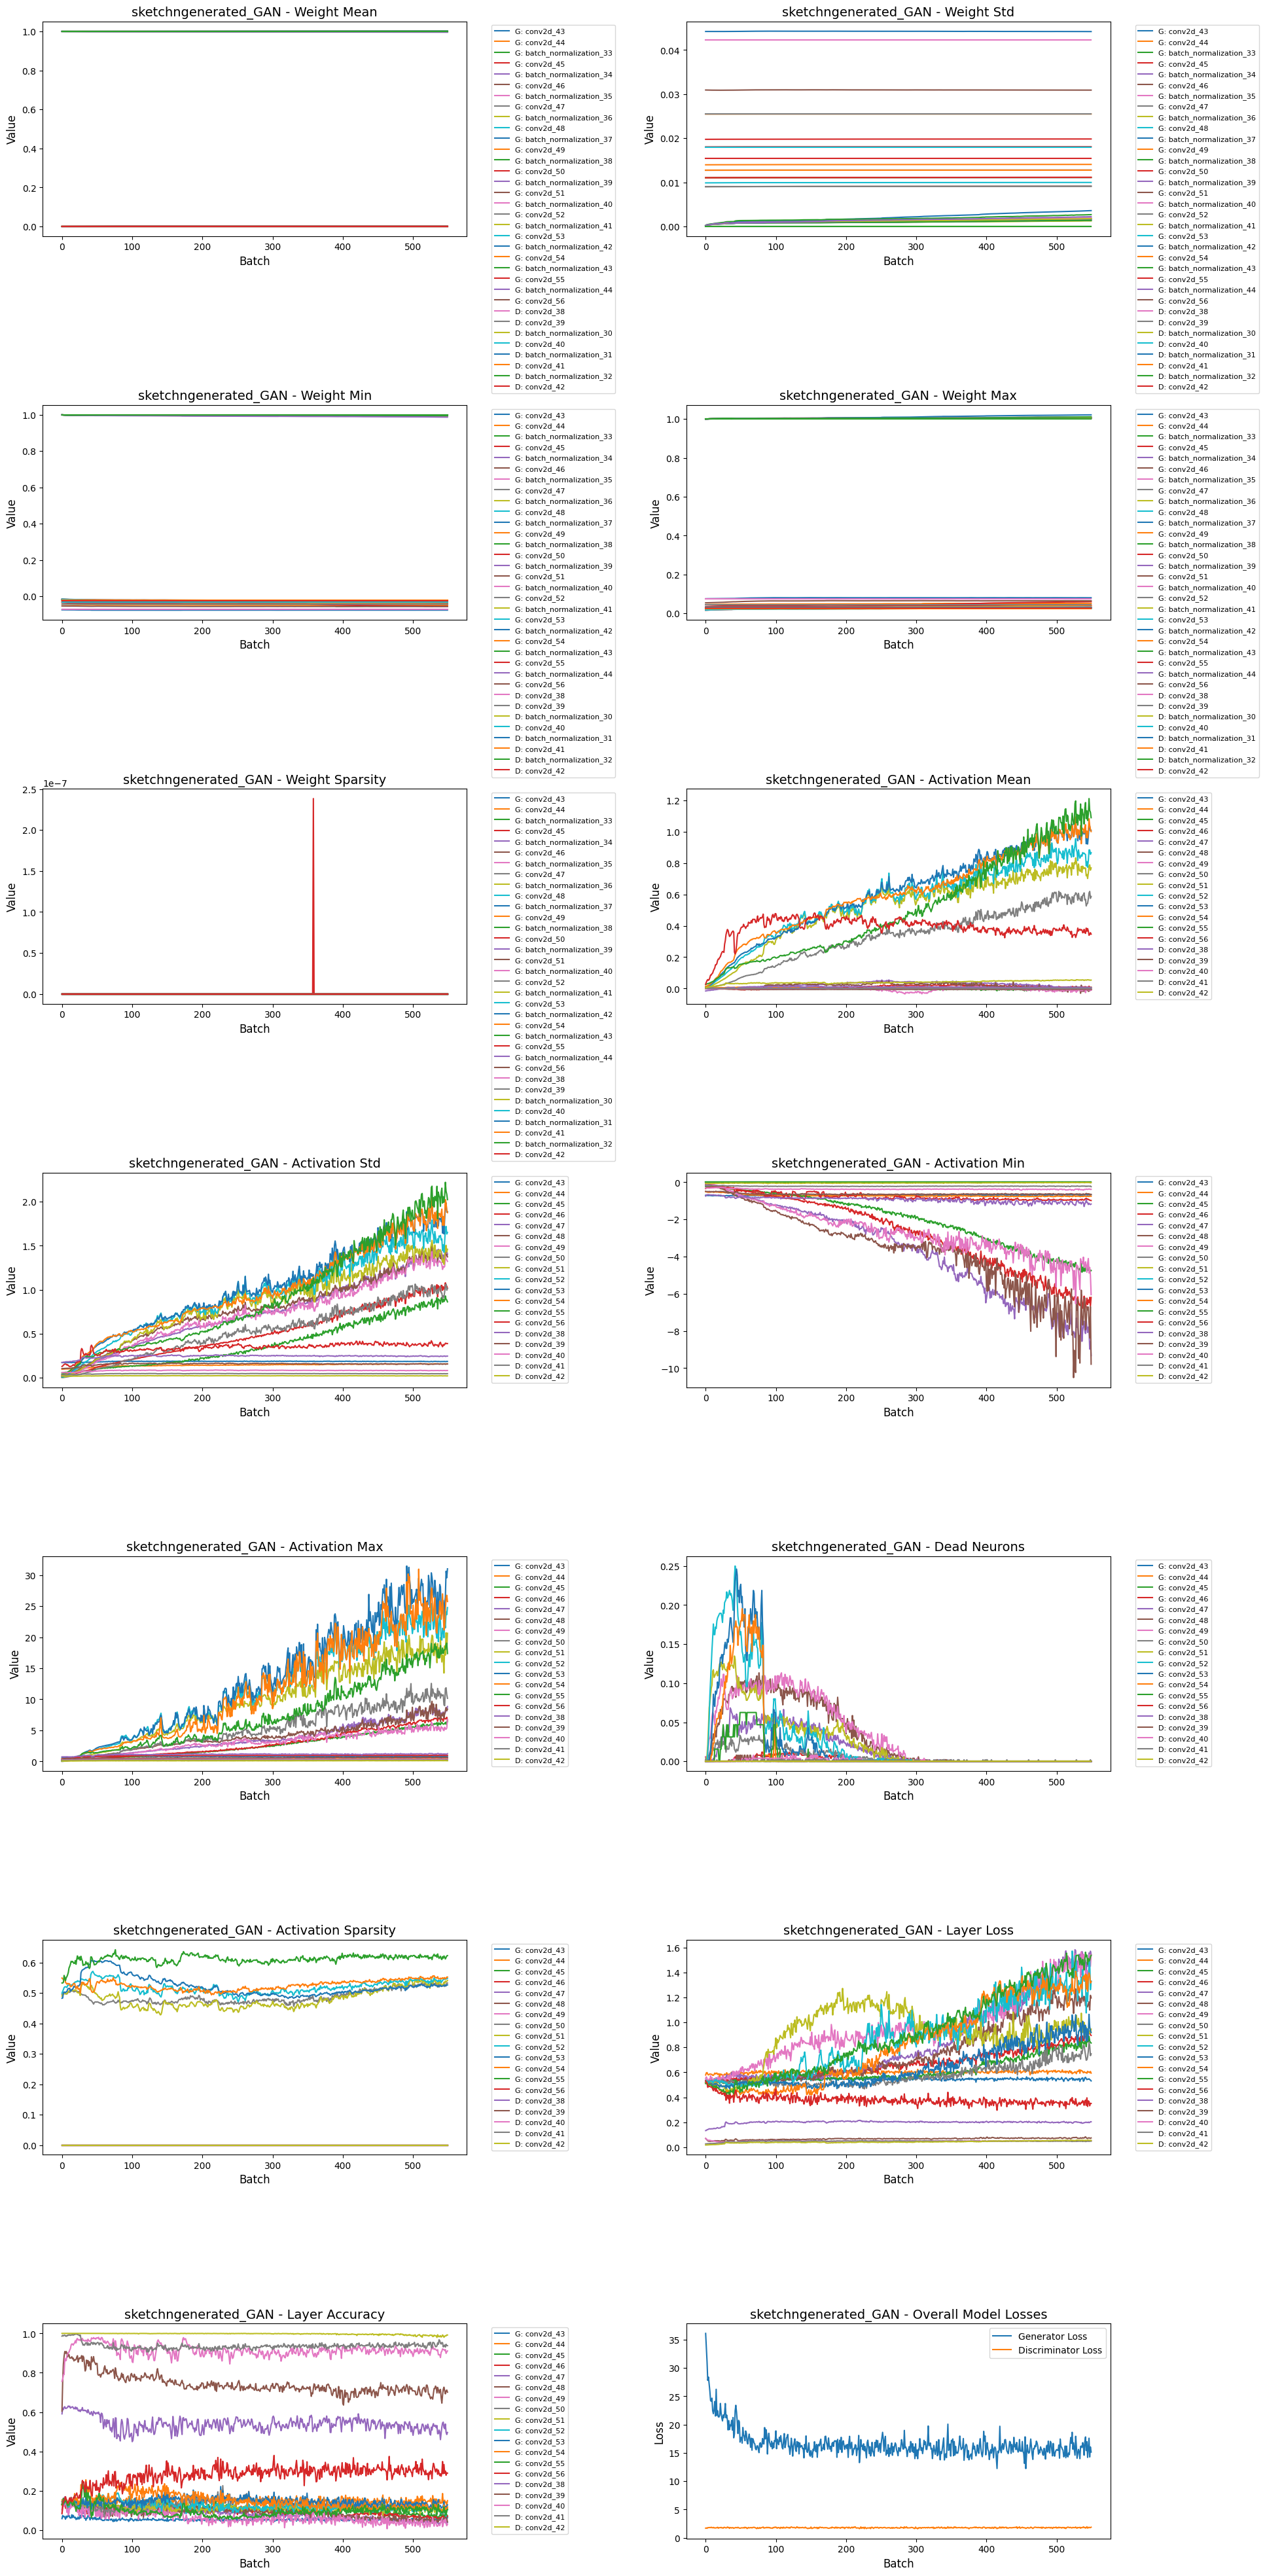

1/1 [==============================] - 0s 426ms/step


Saved performance summary and models for sketchngenerated_GAN at step 1
Training completed for model: sketchngenerated_GAN


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, BatchNormalization, Concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Utility Functions
def load_filename(path):
    dirFiles = os.listdir(path)
    return [os.path.join(path, file) for file in sorted(dirFiles)]

def load_images(list_path, size=(128, 128)):
    return np.array([(np.array(tf.keras.preprocessing.image.load_img(filename, target_size=size)) - 127.5) / 127.5
                     for filename in list_path])

def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1)) * 0.9  # Label smoothing
    return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

def summarize_performance(step, g_model, d_model, dataset, model_name, target_dir='', n_samples=3):
    full_target_dir = target_dir
    if full_target_dir and not os.path.exists(full_target_dir):
        os.makedirs(full_target_dir, exist_ok=True)

    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    plt.figure(figsize=(15, 5*n_samples))

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
        if i == 0:
            plt.title('Input', fontsize=12)

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        if i == 0:
            plt.title('Generated', fontsize=12)

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
        if i == 0:
            plt.title('Ground Truth', fontsize=12)

    plt.suptitle(f'{model_name} - Step {step+1}', fontsize=16)

    filename = f'{model_name}_plot_{step+1:06d}.png'
    plt.savefig(os.path.join(full_target_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

    # Save models
    g_model.save(os.path.join(full_target_dir, f'generator_epoch_{step+1}.h5'))
    d_model.save(os.path.join(full_target_dir, f'discriminator_epoch_{step+1}.h5'))

    print(f'Saved performance summary and models for {model_name} at step {step+1}')

def plot_metrics(g_metrics_history, d_metrics_history, g_loss_history, d_loss_history, epoch, model_name):
    plt.figure(figsize=(20, 40))

    metric_names = ['weight_mean', 'weight_std', 'weight_min', 'weight_max', 'weight_sparsity',
                    'activation_mean', 'activation_std', 'activation_min', 'activation_max',
                    'dead_neurons', 'activation_sparsity', 'layer_loss', 'layer_accuracy']

    for i, metric in enumerate(metric_names):
        plt.subplot(7, 2, i+1)
        for layer in g_metrics_history[0].keys():
            if metric in g_metrics_history[0][layer]:
                values = [m[layer][metric] for m in g_metrics_history if metric in m[layer]]
                if values:
                    plt.plot(values, label=f'G: {layer}')
        for layer in d_metrics_history[0].keys():
            if metric in d_metrics_history[0][layer]:
                values = [m[layer][metric] for m in d_metrics_history if metric in m[layer]]
                if values:
                    plt.plot(values, label=f'D: {layer}')
        plt.title(f'{model_name} - {metric.replace("_", " ").title()}', fontsize=14)
        plt.xlabel('Batch', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        if plt.gca().get_legend_handles_labels()[0]:
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tick_params(axis='both', which='major', labelsize=10)

    plt.subplot(7, 2, 14)
    plt.plot(g_loss_history, label='Generator Loss')
    plt.plot(d_loss_history, label='Discriminator Loss')
    plt.title(f'{model_name} - Overall Model Losses', fontsize=14)
    plt.xlabel('Batch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout(pad=3.0)

    # Save the plot with model name in the filename
    plt.savefig(f'Models/{model_name}/metrics_up_to_epoch_{epoch+1}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def network_metrics(model, inputs, targets, is_discriminator=False):
    metrics = {}
    layer_losses = {}
    layer_accuracies = {}

    for layer in model.layers:
        layer_name = layer.name
        metrics[layer_name] = {}
        layer_losses[layer_name] = []
        layer_accuracies[layer_name] = []

        # Weights metrics
        if layer.weights:
            weights = layer.get_weights()[0]
            metrics[layer_name]['weight_mean'] = np.mean(weights)
            metrics[layer_name]['weight_std'] = np.std(weights)
            metrics[layer_name]['weight_min'] = np.min(weights)
            metrics[layer_name]['weight_max'] = np.max(weights)
            metrics[layer_name]['weight_sparsity'] = np.mean(weights == 0)

        # Activation metrics
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            layer_output = tf.keras.backend.function([model.input], [layer.output])([inputs])[0]
            metrics[layer_name]['activation_mean'] = np.mean(layer_output)
            metrics[layer_name]['activation_std'] = np.std(layer_output)
            metrics[layer_name]['activation_min'] = np.min(layer_output)
            metrics[layer_name]['activation_max'] = np.max(layer_output)
            metrics[layer_name]['dead_neurons'] = np.mean(np.all(layer_output <= 0, axis=(0,1,2)))
            metrics[layer_name]['activation_sparsity'] = np.mean(layer_output == 0)

            if isinstance(layer, tf.keras.layers.Conv2D):
                # Resize targets to match the layer output shape
                resized_targets = tf.image.resize(targets, (layer_output.shape[1], layer_output.shape[2]))

                # If the number of channels doesn't match, take only the first 3 channels of layer_output
                if layer_output.shape[-1] != 3:
                    layer_output = layer_output[..., :3]

                layer_loss = tf.reduce_mean(tf.abs(layer_output - resized_targets)).numpy()
                metrics[layer_name]['layer_loss'] = layer_loss

                # Compute accuracy: percentage of pixels within a certain threshold
                threshold = 0.1
                accuracy = tf.reduce_mean(tf.cast(tf.abs(layer_output - resized_targets) < threshold, tf.float32)).numpy()
                metrics[layer_name]['layer_accuracy'] = accuracy

    return metrics

# Loss Function
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

# Improved Generator
def improved_generator(img_shape):
    def conv2d(layer_in, n_filter, kernel_size=4, strides=2, padding='same'):
        d = Conv2D(n_filter, kernel_size=kernel_size, strides=strides, padding=padding,
                   kernel_constraint=max_norm(1), kernel_regularizer=l2(1e-5))(layer_in)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu',
                   kernel_constraint=max_norm(1), kernel_regularizer=l2(1e-5))(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = BatchNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    in_img = Input(shape=img_shape)

    # Encoder
    e1 = conv2d(in_img, 64)
    e2 = conv2d(e1, 128)
    e3 = conv2d(e2, 256)
    e4 = conv2d(e3, 512)
    e5 = conv2d(e4, 512)
    e6 = conv2d(e5, 512)
    e7 = conv2d(e6, 512)

    # Decoder
    d1 = deconv2d(e7, e6, 512)
    d2 = deconv2d(d1, e5, 512)
    d3 = deconv2d(d2, e4, 512)
    d4 = deconv2d(d3, e3, 256, dropout=0)
    d5 = deconv2d(d4, e2, 128, dropout=0)
    d6 = deconv2d(d5, e1, 64, dropout=0)
    d7 = UpSampling2D(size=2)(d6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(d7)

    return Model(in_img, out_img, name='improved_generator')

# Improved Discriminator
def improved_discriminator(img_shape):
    def d_layer(layer_in, n_filter, kernel_size=4, strides=2, norm=True):
        d = Conv2D(n_filter, kernel_size=kernel_size, strides=strides, padding='same',
                   kernel_constraint=max_norm(1), kernel_regularizer=l2(1e-5))(layer_in)
        d = LeakyReLU(alpha=0.2)(d)
        if norm:
            d = BatchNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='improved_discriminator')

# GAN
def improved_GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='improved_GAN')
    return model

def train(d_model, g_model, gan_model, data, target_dir, model_name, n_epochs=1, n_batch=64):
    n_patch = d_model.output_shape[1]
    blue_photo, blue_sketch = data[0], data[1]

    metrics_buffer = []
    all_g_losses = []
    all_d_losses = []
    batch_count = 0

    # Metrics histories for all epochs
    g_metrics_history = []
    d_metrics_history = []
    g_loss_history = []
    d_loss_history = []

    # Ensure directories exist
    os.makedirs(f'Models/{model_name}/metrics', exist_ok=True)
    os.makedirs(f'Models/{model_name}/output_images', exist_ok=True)

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=2e-4,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True)

    # Optimizers
    d_optimizer = Adam(learning_rate=lr_schedule, beta_1=0.5)
    g_optimizer = Adam(learning_rate=lr_schedule, beta_1=0.5)

    # Compile models
    d_model.compile(loss=wasserstein_loss, optimizer=d_optimizer)
    gan_model.compile(loss=[wasserstein_loss, 'mae'], optimizer=g_optimizer, loss_weights=[1, 100])

    for epoch in range(n_epochs):
        print(f' ========== Epoch {epoch+1} ========== ')
        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        try:
            for j in range(int(len(blue_photo)/n_batch)):
                batch_count += 1
                start = int(j*n_batch)
                end = int(min(len(blue_photo), (j*n_batch)+n_batch))

                dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]
                [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
                X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

                # Train discriminator
                d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
                d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
                d_loss = 0.5 * np.add(d_loss1, d_loss2)

                # Train generator
                g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

                # Calculate network metrics
                g_metrics = network_metrics(g_model, X_realA, X_realB)
                d_metrics = network_metrics(d_model, [X_realA, X_fakeB], y_fake, is_discriminator=True)

                g_metrics_history.append(g_metrics)
                d_metrics_history.append(d_metrics)
                g_loss_history.append(g_loss)
                d_loss_history.append(d_loss)

                metrics_buffer.append({
                    'epoch': epoch + 1,
                    'batch': j + 1,
                    'g_loss': g_loss,
                    'd_loss': d_loss,
                    'g_metrics': g_metrics,
                    'd_metrics': d_metrics
                })

                all_g_losses.append(g_loss)
                all_d_losses.append(d_loss)

                # Save batch-level metrics every 10 batches
                if batch_count % 10 == 0:
                    with open(f'Models/{model_name}/metrics/batch_metrics_{batch_count}.pkl', 'wb') as f:
                        pickle.dump(metrics_buffer, f)
                    metrics_buffer = []  # Clear the buffer after saving

                print(f'Batch : {j+1}, D Loss : {d_loss:.3f} | G Loss : {g_loss:.3f}')

            # Plot metrics for all epochs up to this point
            plot_metrics(g_metrics_history, d_metrics_history,
                         g_loss_history, d_loss_history,
                         epoch, model_name)


            summarize_performance(epoch, g_model, d_model, dataset, model_name, f'Models/{model_name}/output/', n_samples=3)

        except Exception as e:
            print(f"An error occurred during epoch {epoch+1}: {str(e)}")
            # Save any remaining metrics in the buffer
            if metrics_buffer:
                with open(f'Models/{model_name}/metrics/batch_metrics_incomplete_{batch_count}.pkl', 'wb') as f:
                    pickle.dump(metrics_buffer, f)
            raise

    # Save any remaining metrics in the buffer at the end of training
    if metrics_buffer:
        with open(f'Models/{model_name}/metrics/batch_metrics_final_{batch_count}.pkl', 'wb') as f:
            pickle.dump(metrics_buffer, f)

    print(f"Training completed for model: {model_name}")

# Main Execution
if __name__ == '__main__':
    # Load Dataset
    b_photo_path = 'Dataset/Augmented photo/'
    b_sketchngenerated_path = 'Dataset/Augmented sketchngenerated/'

    blue_photo = load_filename(b_photo_path)
    blue_sketchngenerated = load_filename(b_sketchngenerated_path)

    # Define GAN Model
    img_shape = (128, 128, 3)
    d_model = improved_discriminator(img_shape)
    g_model = improved_generator(img_shape)
    gan_model = improved_GAN(g_model, d_model, img_shape)

    # Define the model name and target directory
    model_name = "improved_sketchngenerated_GAN"
    target_dir = 'Models/'

    # Start the training
    train(d_model, g_model, gan_model, data=[blue_sketchngenerated, blue_photo],
          target_dir=target_dir, model_name=model_name, n_epochs=4, n_batch=64)

1/1 [==============================] - 0s 293ms/step


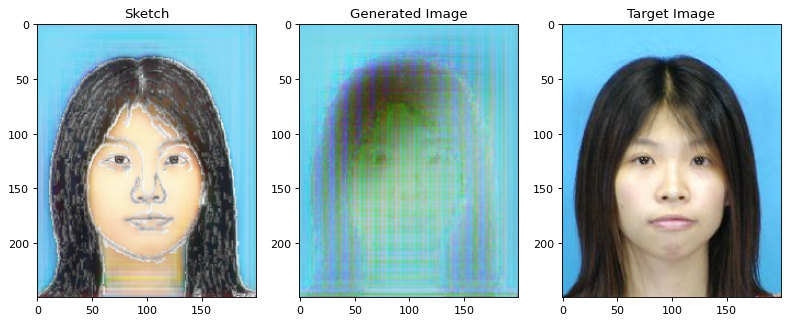

L2-norm: 100.71473693847656 :: SSIM: 0.410100243861047


In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    norm_img = (img - 127.5) / 127.5
    return img, norm_img

# Function to generate image using the model
def generate_image(model, norm_img):
    g_img = model.predict(np.expand_dims(norm_img, 0))[0]
    g_img = g_img * 127.5 + 127.5
    return np.clip(g_img, 0, 255).astype('uint8')

# Function to load image
def load_image(image_path):
    return cv2.imread(image_path)

# Function to compute L2 norm
def compute_l2(img1, img2):
    return np.mean((np.square(img1 - img2)))

# Function to compute SSIM
def compute_ssim(img1, img2):
    grayA = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(grayA, grayB, full=True)
    return score

# Function to resize images to a target shape
def resize_image(image, target_size=(128, 128)):
    return cv2.resize(image, target_size)

# Function to display images
def display_images(img, g_img, target):
    img_resized = resize_image(img, (200, 250))
    g_img_resized = resize_image(g_img, (200, 250))
    target_resized = resize_image(target, (200, 250))

    f = plt.figure(num=None, figsize=(12, 6), dpi=80)
    ax1 = f.add_subplot(1, 3, 1)
    plt.imshow(img_resized.astype('uint8'))
    ax2 = f.add_subplot(1, 3, 2)
    plt.imshow(g_img_resized.astype('uint8'))
    ax3 = f.add_subplot(1, 3, 3)
    plt.imshow(target_resized.astype('uint8'))
    ax1.set_title('Sketch')
    ax2.set_title('Generated Image')
    ax3.set_title('Target Image')
    plt.show(block=True)

# Main execution
def main(sketch_path, target_path, model_path):
    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return

    # Load model
    g_model = load_model(model_path)

    # Load and preprocess sketch image
    img, norm_img = load_and_preprocess_image(sketch_path)

    # Generate image
    g_img = generate_image(g_model, norm_img)

    # Load target image
    target = cv2.cvtColor(load_image(target_path), cv2.COLOR_BGR2RGB)

    # Resize images to the same size for comparison
    g_img_resized = resize_image(g_img, (128, 128))
    target_resized = resize_image(target, (128, 128))

    # Display images
    display_images(img, g_img, target)

    # Compute L2 and SSIM scores
    l2 = compute_l2(g_img_resized, target_resized)
    ssim = compute_ssim(g_img_resized, target_resized)

    print(f"L2-norm: {l2} :: SSIM: {ssim}")

# Example usage
sketch_path = '/content/Dataset/Augmented sketchngenerated/00007.jpg'
target_path = '/content/Dataset/Augmented photo/00007.jpg'
model_path = '/content/Models/improved_sketchngenerated_GAN/output/generator_epoch_1.h5'
main(sketch_path, target_path, model_path)

1/1 [==============================] - 0s 287ms/step
Initial L2-norm: 106.1404 :: SSIM: 0.6623


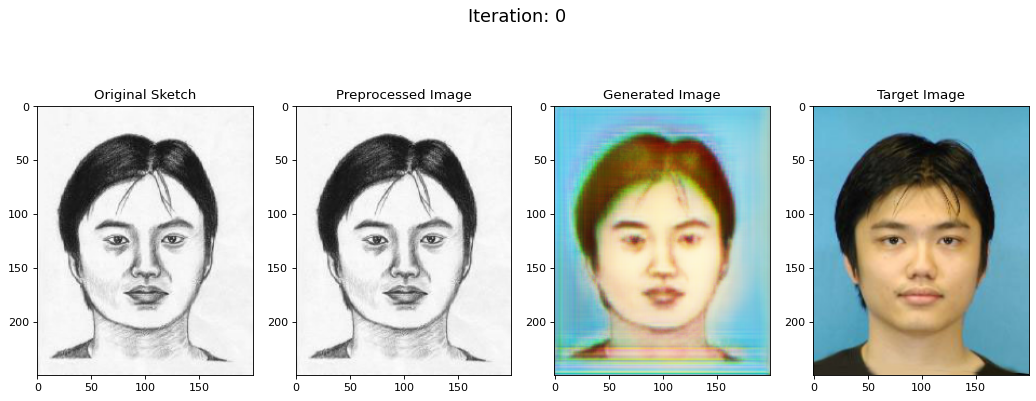

Iteration 1...
1/1 [==============================] - 0s 283ms/step
Iteration 1 L2-norm: 107.2007 :: SSIM: 0.4674


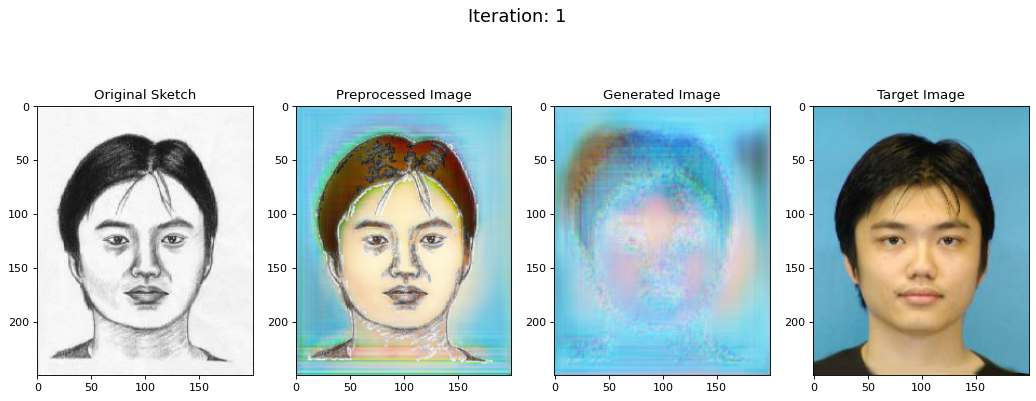

Iteration 2...
1/1 [==============================] - 0s 23ms/step
Iteration 2 L2-norm: 108.5392 :: SSIM: 0.4429


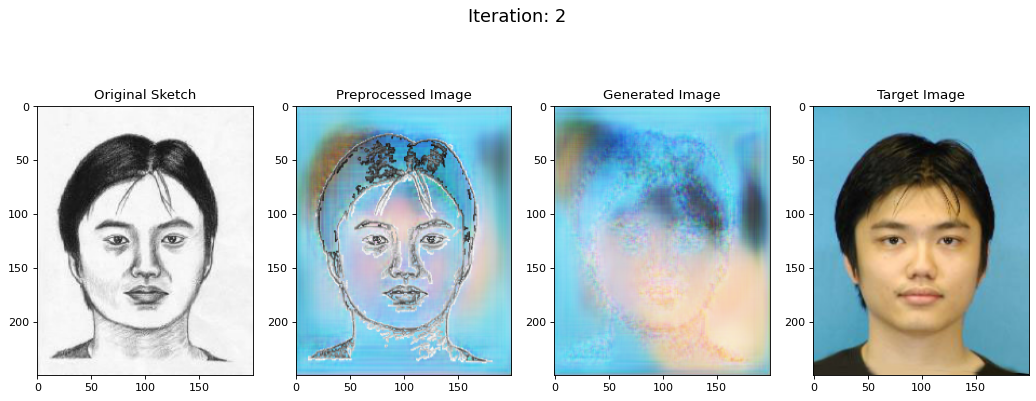

Iteration 3...
1/1 [==============================] - 0s 25ms/step
Iteration 3 L2-norm: 107.6931 :: SSIM: 0.4494


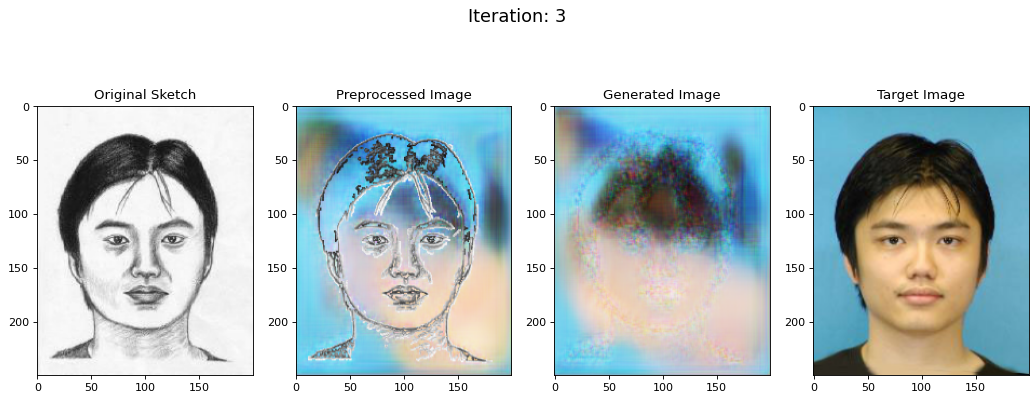

Iteration 4...
1/1 [==============================] - 0s 52ms/step
Iteration 4 L2-norm: 106.5491 :: SSIM: 0.4304


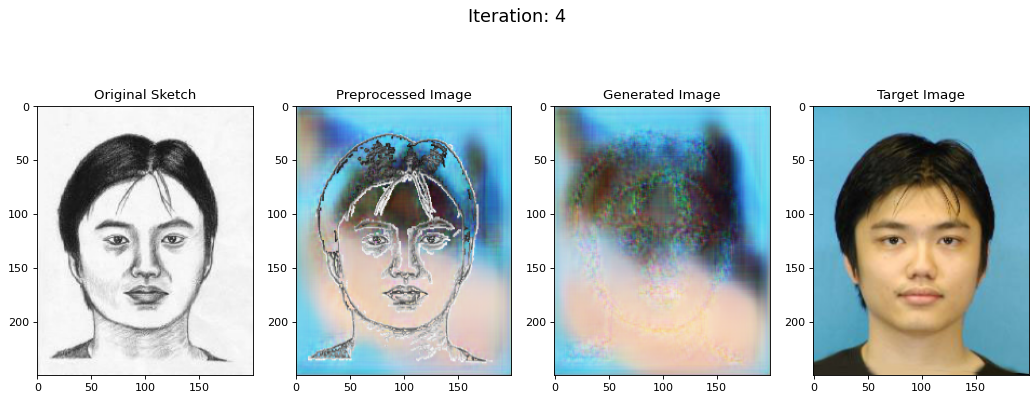

Iteration 5...
1/1 [==============================] - 0s 26ms/step
Iteration 5 L2-norm: 104.7815 :: SSIM: 0.4207


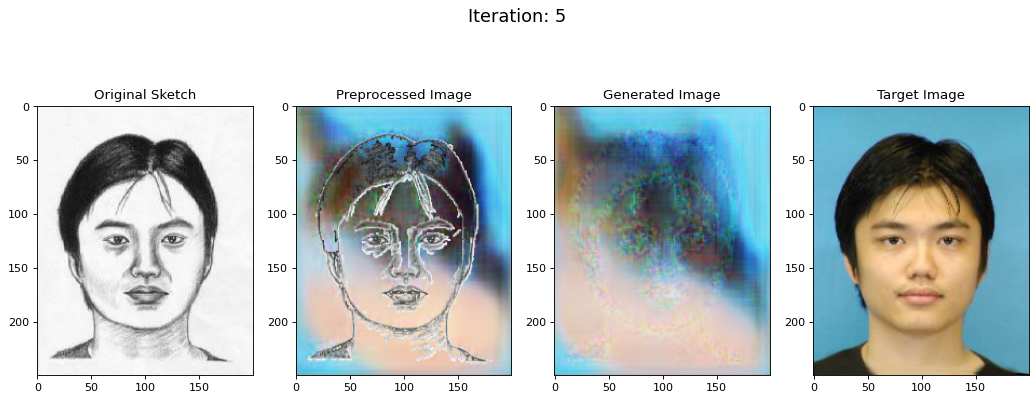

Iteration 6...
1/1 [==============================] - 0s 35ms/step
Iteration 6 L2-norm: 103.9392 :: SSIM: 0.4239


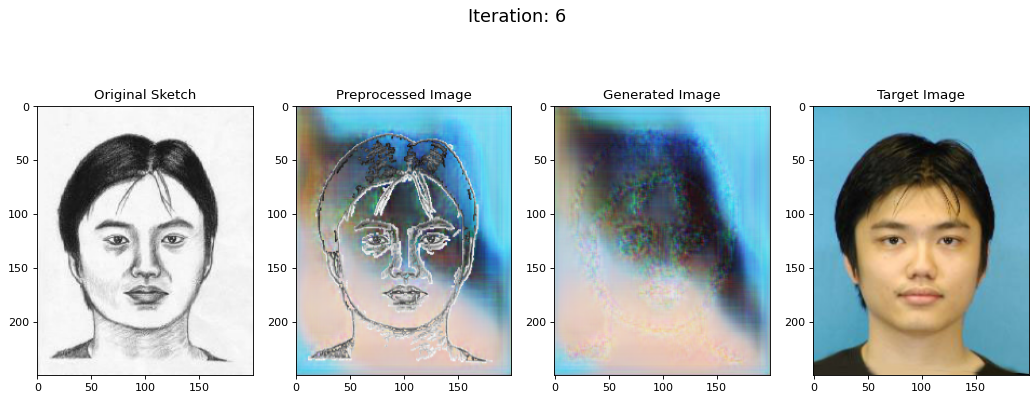

Iteration 7...
1/1 [==============================] - 0s 26ms/step
Iteration 7 L2-norm: 106.5865 :: SSIM: 0.4120


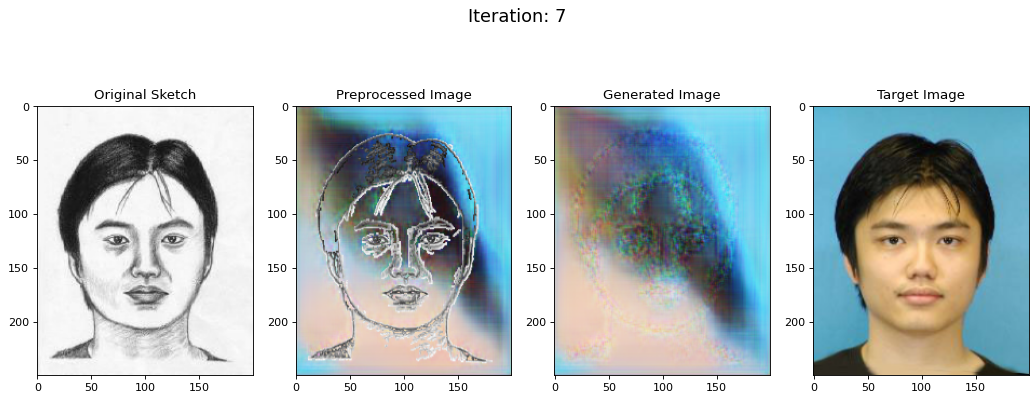

Iteration 8...
1/1 [==============================] - 0s 26ms/step
Iteration 8 L2-norm: 106.8539 :: SSIM: 0.4298


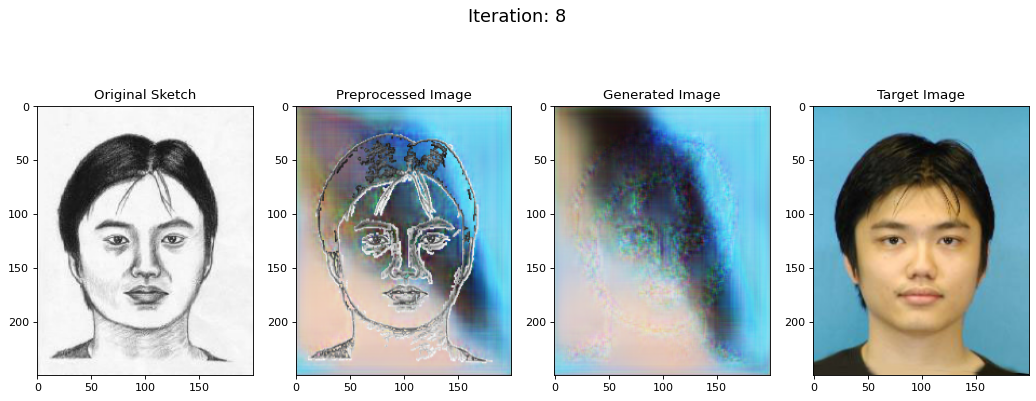

Iteration 9...
1/1 [==============================] - 0s 29ms/step
Iteration 9 L2-norm: 108.2644 :: SSIM: 0.4428


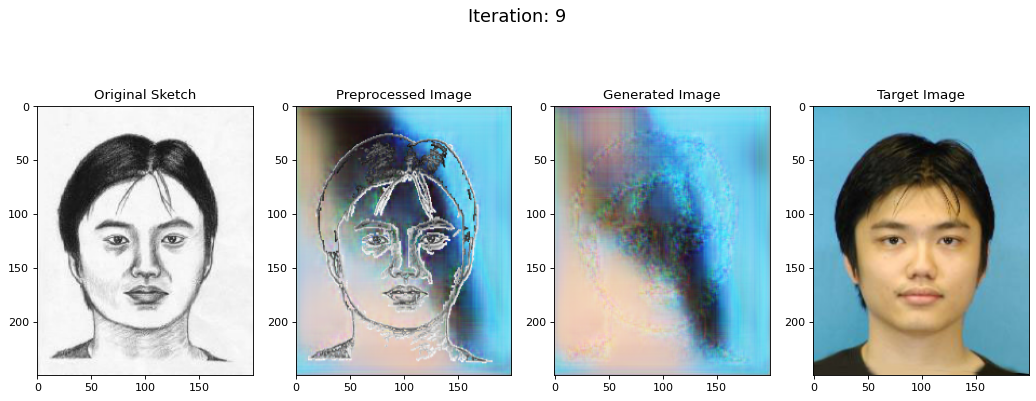

Iteration 10...
1/1 [==============================] - 0s 28ms/step
Iteration 10 L2-norm: 106.5814 :: SSIM: 0.4342


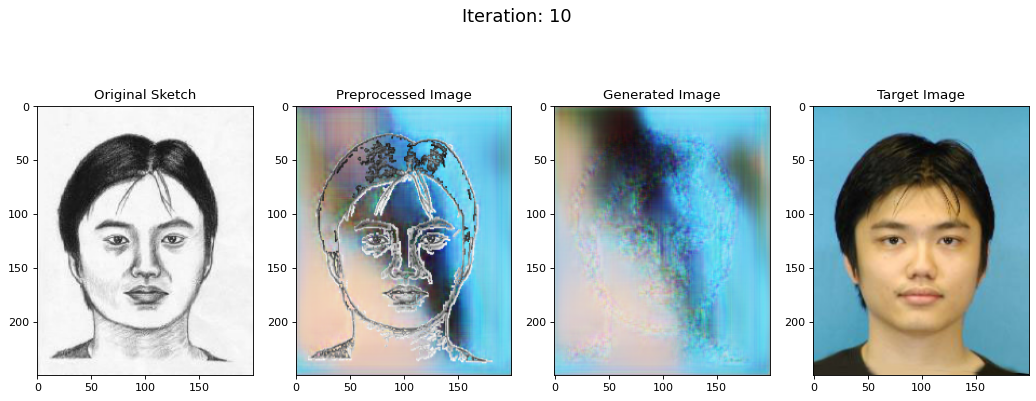

No improvement for 10 iterations. Stopping.


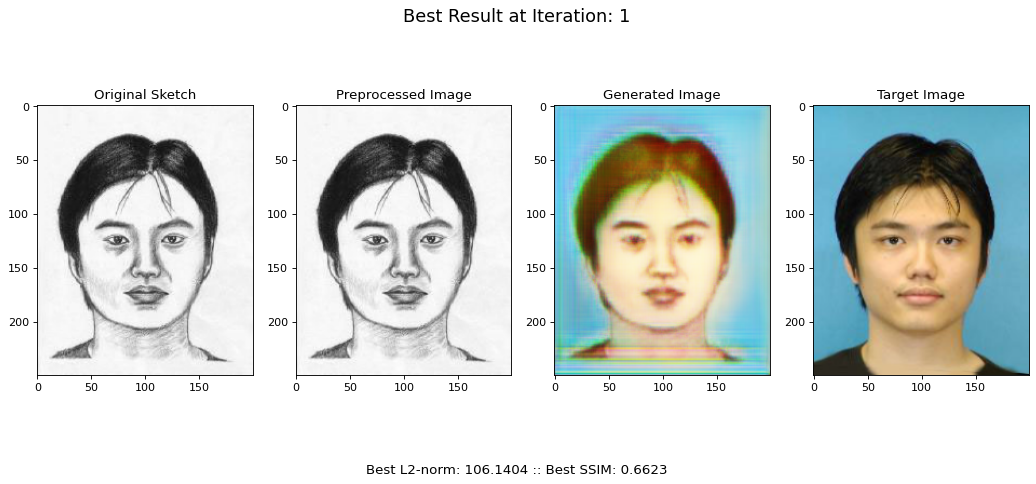

Processing complete. Best image saved as 'best_image.png'. Best result at iteration 1.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import structural_similarity as ssim

# Function to load and preprocess image
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    norm_img = (img - 127.5) / 127.5
    return img, norm_img

# Function to generate image using the model
def generate_image(model, norm_img):
    g_img = model.predict(np.expand_dims(norm_img, 0))[0]
    g_img = g_img * 127.5 + 127.5
    return np.clip(g_img, 0, 255).astype('uint8')

# Function to load image
def load_image(image_path):
    return cv2.imread(image_path)

# Function to compute L2 norm
def compute_l2(img1, img2):
    return np.mean(np.square(img1 - img2))

# Function to compute SSIM
def compute_ssim(img1, img2):
    grayA = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(grayA, grayB, full=True)
    return score

# Function to resize images to a target shape
def resize_image(image, target_size=(128, 128)):
    return cv2.resize(image, target_size)

# Function to display images
def display_images(img, g_img, target, preprocessed_img, iteration=None, best_iteration=None, best_metrics=None):
    img_resized = resize_image(img, (200, 250))
    g_img_resized = resize_image(g_img, (200, 250))
    target_resized = resize_image(target, (200, 250))
    preprocessed_img_resized = resize_image((preprocessed_img * 127.5 + 127.5).astype('uint8'), (200, 250))

    f = plt.figure(num=None, figsize=(16, 6), dpi=80)
    ax1 = f.add_subplot(1, 4, 1)
    plt.imshow(img_resized.astype('uint8'))
    ax2 = f.add_subplot(1, 4, 2)
    plt.imshow(preprocessed_img_resized)
    ax3 = f.add_subplot(1, 4, 3)
    plt.imshow(g_img_resized.astype('uint8'))
    ax4 = f.add_subplot(1, 4, 4)
    plt.imshow(target_resized.astype('uint8'))
    ax1.set_title('Original Sketch')
    ax2.set_title('Preprocessed Image')
    ax3.set_title('Generated Image')
    ax4.set_title('Target Image')

    if iteration is not None:
        plt.suptitle(f'Iteration: {iteration}', fontsize=16)
    elif best_iteration is not None:
        plt.suptitle(f'Best Result at Iteration: {best_iteration + 1}', fontsize=16)

    if best_metrics is not None:
        plt.figtext(0.5, 0.01, f'Best L2-norm: {best_metrics[0]:.4f} :: Best SSIM: {best_metrics[1]:.4f}', ha='center', fontsize=12)

    plt.show(block=True)

def process_image(sketch, g_img):
    sketch = resize_image(sketch, (128, 128))
    g_img = resize_image(g_img, (128, 128))

    # Create a mask for the sketch border
    sketch_gray = cv2.cvtColor(sketch.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(sketch_gray, 100, 200)

    # Slightly dilate the edges to make them a bit thicker
    kernel = np.ones((2, 2), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    # Create the final image by overlaying the generated image on the sketch
    final_img = sketch.copy()
    mask = edges == 0
    final_img[mask] = g_img[mask]

    return final_img

# Main execution with iterative processing and model switching
def main(sketch_path, target_path, model_path1, model_path2, max_iterations=10, no_improvement_limit=10):
    # Load models
    g_model1 = load_model(model_path1)
    g_model2 = load_model(model_path2)

    # Load and preprocess original sketch image
    original_sketch, norm_original_sketch = load_and_preprocess_image(sketch_path)

    # Generate initial image using g_model1
    initial_generated = generate_image(g_model1, norm_original_sketch)

    # Load target image
    target = cv2.cvtColor(load_image(target_path), cv2.COLOR_BGR2RGB)
    target_resized = resize_image(target, (128, 128))

    # Compute initial metrics
    best_l2 = compute_l2(resize_image(initial_generated, (128, 128)), target_resized)
    best_ssim = compute_ssim(resize_image(initial_generated, (128, 128)), target_resized)
    best_image = initial_generated.copy()
    no_improvement_count = 0
    best_iteration = 0

    print(f"Initial L2-norm: {best_l2:.4f} :: SSIM: {best_ssim:.4f}")

    # Display initial images
    display_images(original_sketch, initial_generated, target_resized, norm_original_sketch, iteration=0)

    # Iteratively process the image using g_model2
    current_input = initial_generated
    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}...")

        # Apply process_image to the current input
        processed_img = process_image(original_sketch, current_input)

        # Generate new image using g_model2
        norm_processed_img = (processed_img - 127.5) / 127.5
        generated_img = generate_image(g_model2, norm_processed_img)

        # Compute metrics for the generated image
        current_l2 = compute_l2(resize_image(generated_img, (128, 128)), target_resized)
        current_ssim = compute_ssim(resize_image(generated_img, (128, 128)), target_resized)

        print(f"Iteration {iteration + 1} L2-norm: {current_l2:.4f} :: SSIM: {current_ssim:.4f}")

        if current_l2 < best_l2 and current_ssim > best_ssim:
            best_l2 = current_l2
            best_ssim = current_ssim
            best_image = generated_img.copy()
            best_iteration = iteration
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Display images after processing
        display_images(original_sketch, generated_img, target_resized, norm_processed_img, iteration=iteration+1)

        # Save the processed image of this iteration
        cv2.imwrite(f'processed_image_{iteration}.png', generated_img)

        # Update current input for next iteration
        current_input = generated_img

        if no_improvement_count >= no_improvement_limit:
            print(f"No improvement for {no_improvement_limit} iterations. Stopping.")
            break

    # Display and save the best image
    display_images(original_sketch, best_image, target_resized, norm_original_sketch,
                   best_iteration=best_iteration, best_metrics=(best_l2, best_ssim))
    cv2.imwrite('best_image.png', best_image)
    print(f"Processing complete. Best image saved as 'best_image.png'. Best result at iteration {best_iteration + 1}.")

# Example usage
sketch_path = '/content/Dataset/Augmented sketch/00007.jpg'
target_path = '/content/Dataset/Augmented photo/00007.jpg'
model_path1 = '/content/generator_epoch_1.h5'
model_path2 = '/content/Models/sketchngenerated_GAN/output/generator_epoch_1.h5'
main(sketch_path, target_path, model_path1, model_path2)
